## Step 0: Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import beta

## Step 1: Transform and split the data

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [3]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 1.95
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [4]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [5]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

In [6]:
# look up zero-inflated fits for beta, we're throwing out a small fraction of 0-like videos
prior_a, prior_b, loc, scale = beta.fit([i for i in train_videos.values if i != 0], floc=0, fscale=1)

In [7]:
r = beta.rvs(prior_a, prior_b, size=5000)

Text(0.5, 1.0, 'density plot of eb beta prior')

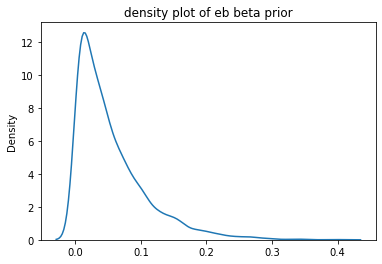

In [8]:
sns.kdeplot(r).set_title('density plot of eb beta prior')

## Step 2: Merge the datasets and select from test set different products

In [9]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.rename(columns={'liked_x': 'liked', 'liked_y': 'like_ratio'})

In [10]:
kuairec_test.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,liked,like_ratio
0,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,0,0.145996
1,19,183,8033,6100,2020-07-25 09:51:33.664,20200725.0,1.595642e+09,1.316885,0,0.145996
2,21,183,15770,6100,2020-07-08 07:00:20.865,20200708.0,1.594163e+09,2.585246,1,0.145996
3,23,183,20786,6100,2020-07-05 07:50:01.81,20200705.0,1.593907e+09,3.407541,1,0.145996
4,24,183,4737,6100,2020-07-05 03:47:59.561,20200705.0,1.593892e+09,0.776557,0,0.145996


Text(0.5, 1.0, 'histogram of like ratios')

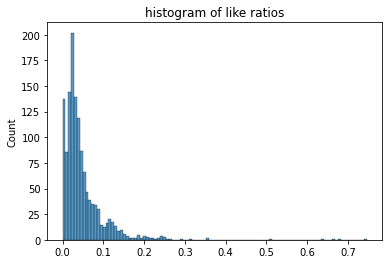

In [11]:
sns.histplot(test_videos.values).set_title('histogram of like ratios')

In [12]:
sampled_videos = (list(test_videos[test_videos > 0.6].sample(2, random_state=1729).keys()) +
    list(test_videos[test_videos <= 0.6].sample(4, random_state=1729).keys()))

In [13]:
sampled_videos

[4123, 1305, 3921, 3019, 6320, 3958]

In [14]:
kuairec_chosen = kuairec_test[kuairec_test['video_id'].isin(sampled_videos)]

In [15]:
video_df[sampled_videos]

video_id
4123    0.639263
1305    0.676596
3921    0.105599
3019    0.062367
6320    0.052482
3958    0.066176
Name: liked, dtype: float64

## Step 3: Set up the bandit environment

In [16]:
# set up experiment in a way where we can later interpolate between uninformed prior and eb
uninformed_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2)
eb_priors = np.array([[prior_a]*len(sampled_videos),[prior_b]*len(sampled_videos)]).T

In [17]:
def random_argmax(alist):
  maxval = max(alist)
  argmax = [idx for idx, val in enumerate(alist) if val == maxval]
  return np.random.choice(argmax)

def ts_action(actions, num_success, num_failure):
  p_hat = [np.random.beta(num_success[a],num_failure[a]) for a in actions]
  a = random_argmax(p_hat)
  return a

def greedy_action(actions, num_success, num_failure):
  p_hat = [(num_success[a] + 1) / (num_success[a] + num_failure[a] + 2) for a in actions]
  a = random_argmax(p_hat)
  return a

def epsilon_greedy_action(actions, num_success, num_failure):
  if np.random.binomial(1, 0.05):
    a = np.random.choice(actions)
  else:
    a = greedy_action(actions, num_success, num_failure)
  return a

def sample_chosen_df(videos, chosen_df, action_index):
    vid = videos[action_index]
    seen_like = chosen_df[chosen_df['video_id']==vid].sample(1).iloc[0]['liked']
    return seen_like

In [18]:
def run_multiarmed_bandit(chosen_df, 
                          videos, 
                          priors, 
                          sampling_action, 
                          timesteps, 
                          num_sims):

    agg_priors_over_time = None
    rewards_over_time = None
    plays = np.zeros(len(videos))
    
    for n in range(num_sims):
        instance_priors_over_time = [priors]
        instance_rewards_over_time = [np.zeros(len(videos))]
        
        for t in range(timesteps):
            newest_prior = instance_priors_over_time[-1].copy()
            newest_rewards = instance_rewards_over_time[-1].copy()
            successes, failures = newest_prior.T[0,:], newest_prior.T[1,:]
            actions = range(len(videos))
            
            a = sampling_action(actions, successes, failures)
            
            plays[a] += 1
            
            like = sample_chosen_df(videos, chosen_df, a)
            
            # update prior
            newest_prior[a,0] += like
            newest_prior[a,1] += 1 - like
            instance_priors_over_time.append(newest_prior)
            
            newest_rewards[a] += like
            instance_rewards_over_time.append(newest_rewards)
            
        instance_priors_over_time = np.stack(instance_priors_over_time)
        instance_rewards_over_time = np.stack(instance_rewards_over_time)
        
        if agg_priors_over_time is None:
            agg_priors_over_time = instance_priors_over_time
        else:
            agg_priors_over_time += instance_priors_over_time
            
        if rewards_over_time is None:
            rewards_over_time = instance_rewards_over_time
        else:
            rewards_over_time += instance_rewards_over_time
            
    return agg_priors_over_time/num_sims, rewards_over_time/num_sims, plays/num_sims
            
        

## Step 4: Run the simulations and save data

In [19]:
timesteps = 1000
num_sims = 10

In [20]:
uninformed_prior_data, uninformed_rewards_data, uninformed_plays = run_multiarmed_bandit(kuairec_chosen,
                                                                       sampled_videos,
                                                                       uninformed_priors,
                                                                       ts_action,
                                                                       timesteps=timesteps,
                                                                       num_sims=num_sims)

In [21]:
eb_prior_data, eb_rewards_data, eb_plays = run_multiarmed_bandit(kuairec_chosen,
                                                       sampled_videos,
                                                       eb_priors,
                                                       ts_action,
                                                       timesteps=timesteps,
                                                       num_sims=num_sims)

In [22]:
uninformed_greedy_prior_data, uninformed_greedy_rewards_data, uninformed_greedy_plays = run_multiarmed_bandit(kuairec_chosen,
                                                                       sampled_videos,
                                                                       uninformed_priors,
                                                                       epsilon_greedy_action,
                                                                       timesteps=timesteps,
                                                                       num_sims=num_sims)

In [23]:
eb_greedy_prior_data, eb_greedy_rewards_data, eb_greedy_plays = run_multiarmed_bandit(kuairec_chosen,
                                                                       sampled_videos,
                                                                       eb_priors,
                                                                       epsilon_greedy_action,
                                                                       timesteps=timesteps,
                                                                       num_sims=num_sims)

## Step 5: Plot and analyze the data

In [24]:
uninformed_means = uninformed_prior_data[:,:,0]/(uninformed_prior_data[:,:,0]+uninformed_prior_data[:,:,1])
eb_means = eb_prior_data[:,:,0]/(eb_prior_data[:,:,0] + eb_prior_data[:,:,1])
uninformed_greedy_means = uninformed_greedy_prior_data[:,:,0]/(uninformed_greedy_prior_data[:,:,0] + uninformed_greedy_prior_data[:,:,1])
eb_greedy_means = eb_greedy_prior_data[:,:,0]/(eb_greedy_prior_data[:,:,0] + eb_greedy_prior_data[:,:,1])

In [25]:
uninf_conf_width = beta.interval(0.95, uninformed_prior_data[:,:,0], uninformed_prior_data[:,:,1])
uninf_conf_width = uninf_conf_width[1] - uninf_conf_width[0]
eb_conf_width = beta.interval(0.95, eb_prior_data[:,:,0], eb_prior_data[:,:,1])
eb_conf_width = eb_conf_width[1] - eb_conf_width[0]
uninf_greedy_conf_width = beta.interval(0.95, uninformed_greedy_prior_data[:,:,0], uninformed_greedy_prior_data[:,:,1])
uninf_greedy_conf_width = uninf_greedy_conf_width[1] - uninf_greedy_conf_width[0]
eb_greedy_conf_width = beta.interval(0.95, eb_greedy_prior_data[:,:,0], eb_greedy_prior_data[:,:,1])
eb_greedy_conf_width = eb_greedy_conf_width[1] - eb_greedy_conf_width[0]

estimated means [0.61122661 0.67243451 0.22330097 0.1627907  0.1686747  0.18072289]
arm pulls [142.3 830.2   8.3   6.6   6.3   6.3]


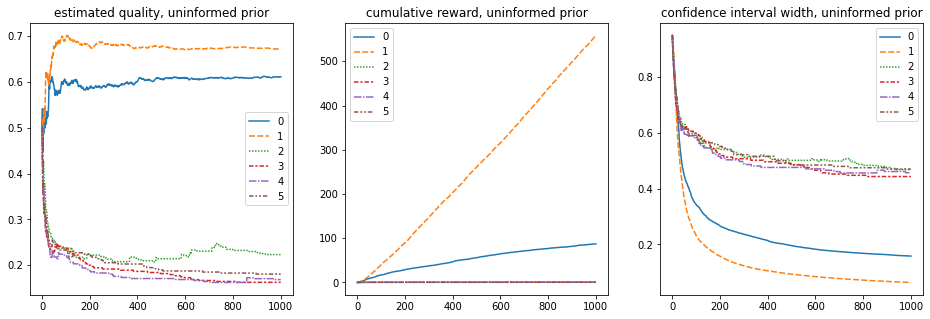

In [26]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(16, 5)
sns.lineplot(uninformed_means, ax=axes[0]).set_title('estimated quality, uninformed prior')
sns.lineplot(uninformed_rewards_data, ax=axes[1]).set_title('cumulative reward, uninformed prior')
sns.lineplot(uninf_conf_width, ax=axes[2]).set_title('confidence interval width, uninformed prior')
print('estimated means', uninformed_means[-1,:])
print('arm pulls', uninformed_plays)

estimated means [0.60606449 0.66463947 0.05990836 0.06128737 0.05026922 0.04847244]
arm pulls [315.4 676.5   1.7   2.9   1.4   2.1]


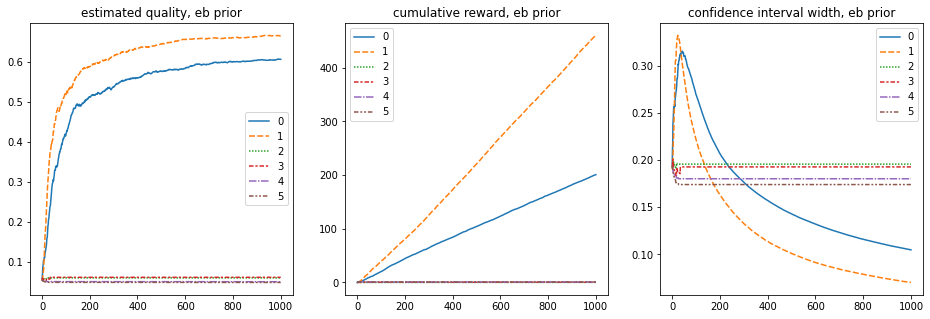

In [27]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(16, 5)
sns.lineplot(eb_means, ax=axes[0]).set_title('estimated quality, eb prior')
sns.lineplot(eb_rewards_data, ax=axes[1]).set_title('cumulative reward, eb prior')
sns.lineplot(eb_conf_width, ax=axes[2]).set_title('confidence interval width, eb prior')
print('estimated means', eb_means[-1,:])
print('arm pulls', eb_plays)

estimated means [0.64645427 0.68573798 0.16037736 0.1559633  0.14150943 0.15454545]
arm pulls [484.5 480.4   8.6   8.9   8.6   9. ]


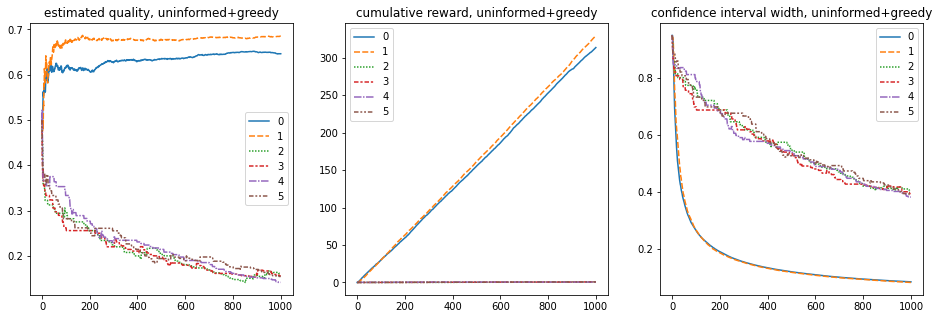

In [28]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(16, 5)
sns.lineplot(uninformed_greedy_means, ax=axes[0]).set_title('estimated quality, uninformed+greedy')
sns.lineplot(uninformed_greedy_rewards_data, ax=axes[1]).set_title('cumulative reward, uninformed+greedy')
sns.lineplot(uninf_greedy_conf_width, ax=axes[2]).set_title('confidence interval width, uninformed+greedy')
print('estimated means', uninformed_greedy_means[-1,:])
print('arm pulls', uninformed_greedy_plays)

estimated means [0.6205657  0.65562392 0.07305049 0.08037728 0.04355993 0.05124041]
arm pulls [479.4 481.2   9.2  10.5   8.9  10.8]


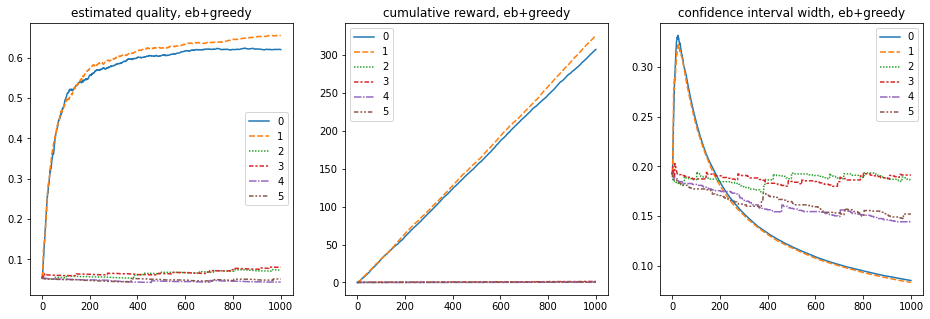

In [29]:
f, axes = plt.subplots(1, 3)
f.set_size_inches(16, 5)
sns.lineplot(eb_greedy_means, ax=axes[0]).set_title('estimated quality, eb+greedy')
sns.lineplot(eb_greedy_rewards_data, ax=axes[1]).set_title('cumulative reward, eb+greedy')
sns.lineplot(eb_greedy_conf_width, ax=axes[2]).set_title('confidence interval width, eb+greedy')
print('estimated means', eb_greedy_means[-1,:])
print('arm pulls', eb_greedy_plays)